https://mne.tools/stable/auto_tutorials/time-freq/plot_sensors_time_frequency.html#sphx-glr-auto-tutorials-time-freq-plot-sensors-time-frequency-py

In [1]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Stefan Appelhoff <stefan.appelhoff@mailbox.org>
#          Richard Höchenberger <richard.hoechenberger@gmail.com>
#
# License: BSD (3-clause)
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne.datasets import somato

In [2]:
data_path = somato.data_path()
subject = '01'
task = 'somato'
raw_fname = op.join(data_path, 'sub-{}'.format(subject), 'meg',
                    'sub-{}_task-{}_meg.fif'.format(subject, task))

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel='STI 014')

# picks MEG gradiometers
picks = mne.pick_types(raw.info, meg='grad', eeg=False, eog=True, stim=False)

# Construct Epochs
event_id, tmin, tmax = 1, -1., 3.
baseline = (None, 0)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=baseline, reject=dict(grad=4000e-13, eog=350e-6),
                    preload=True)

epochs.resample(200., npad='auto')  # resample to reduce computation time

Using default location ~/mne_data for somato...


  0%|          | Downloading : 0.00/582M [00:00<?,        ?B/s]

Verifying hash 32fd2f6c8c7eb0784a1de6435273c48b.
Decompressing the archive: /Users/niwa/mne_data/MNE-somato-data.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['/Users/niwa/mne_data/MNE-somato-data']
Opening raw data file /Users/niwa/mne_data/MNE-somato-data/sub-01/meg/sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
111 events found
Event IDs: [1]
Not setting metadata
Not setting metadata
111 matching events found
Setting baseline interval to [-0.9989760657919393, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 111 events and 1202 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
3 bad epochs dropped


<Epochs |  108 events (all good), -0.998976 - 3.00102 sec, baseline [-0.998976, 0] sec, ~138.5 MB, data loaded,
 '1': 108>

    Using multitaper spectrum estimation with 7 DPSS windows


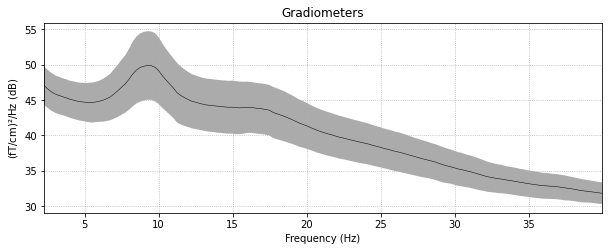

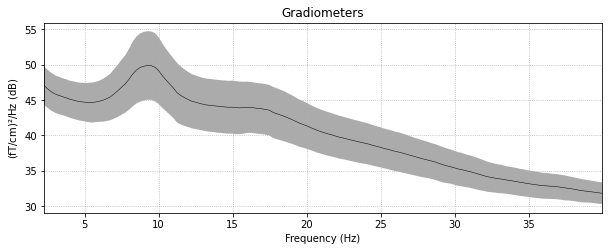

In [3]:
epochs.plot_psd(fmin=2., fmax=40., average=True, spatial_colors=False)

    Using multitaper spectrum estimation with 7 DPSS windows


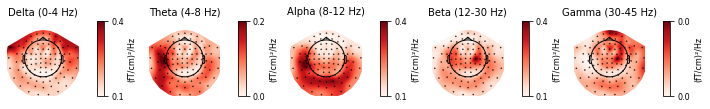

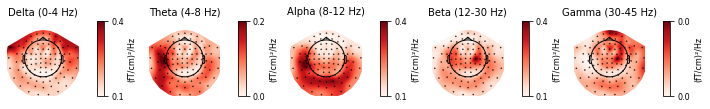

In [4]:
epochs.plot_psd_topomap(ch_type='grad', normalize=True)

    Using multitaper spectrum estimation with 7 DPSS windows


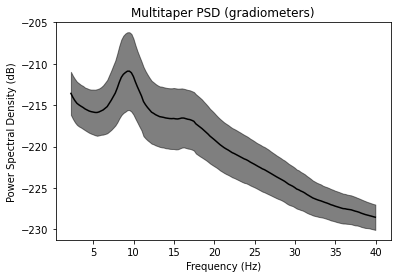

In [5]:
f, ax = plt.subplots()
psds, freqs = psd_multitaper(epochs, fmin=2, fmax=40, n_jobs=1)
psds = 10. * np.log10(psds)
psds_mean = psds.mean(0).mean(0)
psds_std = psds.mean(0).std(0)

ax.plot(freqs, psds_mean, color='k')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)
ax.set(title='Multitaper PSD (gradiometers)', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (dB)')
plt.show()

Effective window size : 1.280 (s)
Effective window size : 1.280 (s)


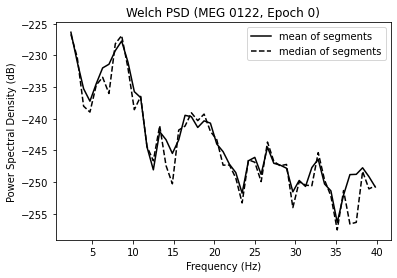

In [6]:
kwargs = dict(fmin=2, fmax=40, n_jobs=1)
psds_welch_mean, freqs_mean = psd_welch(epochs, average='mean', **kwargs)
psds_welch_median, freqs_median = psd_welch(epochs, average='median', **kwargs)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'MEG 0122'
ch_idx = epochs.info['ch_names'].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_mean[epo_idx, ch_idx, :], color='k',
        ls='-', label='mean of segments')
ax.plot(freqs_median, psds_welch_median[epo_idx, ch_idx, :], color='k',
        ls='--', label='median of segments')

ax.set(title='Welch PSD ({}, Epoch {})'.format(ch_name, epo_idx),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

In [7]:
psds_welch_unagg, freqs_unagg = psd_welch(epochs, average=None, **kwargs)
print(psds_welch_unagg.shape)

Effective window size : 1.280 (s)
(108, 204, 49, 3)


In [8]:
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

Applying baseline correction (mode: logratio)


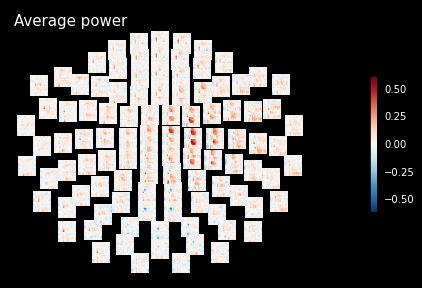

Applying baseline correction (mode: logratio)


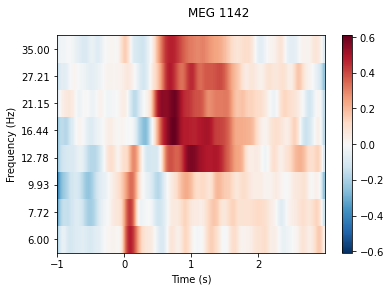

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


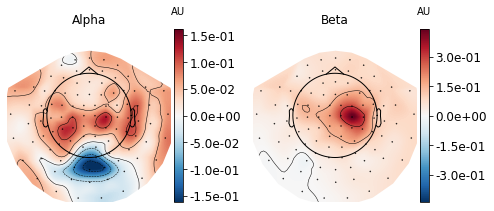

In [9]:
power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power')
power.plot([82], baseline=(-0.5, 0), mode='logratio', title=power.ch_names[82])

fig, axis = plt.subplots(1, 2, figsize=(7, 4))
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[0],
                   title='Alpha', show=False)
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=13, fmax=25,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[1],
                   title='Beta', show=False)
mne.viz.tight_layout()
plt.show()

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


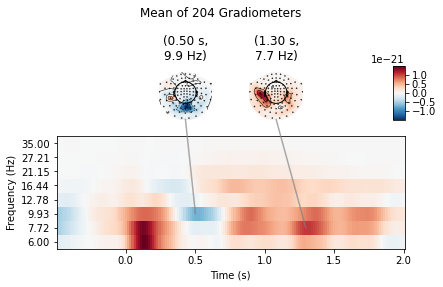

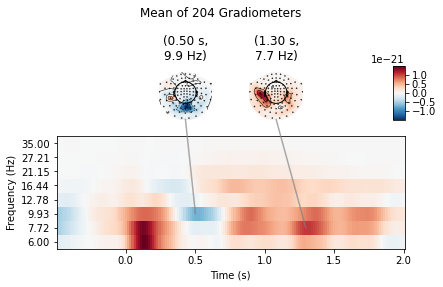

In [10]:
power.plot_joint(baseline=(-0.5, 0), mode='mean', tmin=-.5, tmax=2,
                 timefreqs=[(.5, 10), (1.3, 8)])

No baseline correction applied


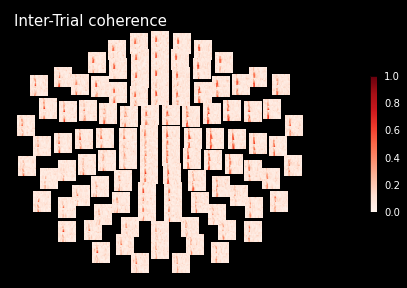

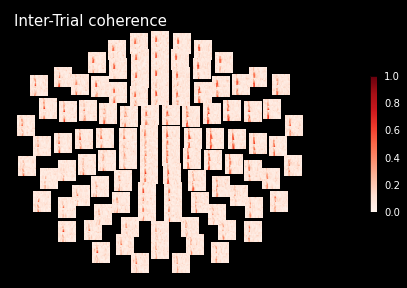

In [11]:
itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds')